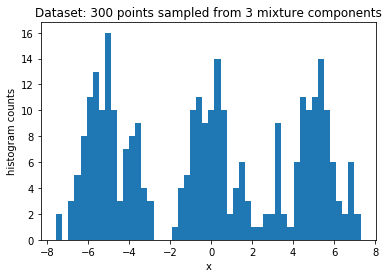

In [70]:
# Just RJMC for GMMs:
import matplotlib.pyplot as plt
%matplotlib inline

from autograd import numpy as np
np.random.seed(0)
from scipy.stats import norm
from scipy.special import logsumexp, factorial

def gaussian_mixture_log_likelihood(X, means, stdevs, weights):
    component_log_pdfs = np.array([norm.logpdf(X, loc=mean, scale=stdev) + np.log(weight) for ((mean, stdev), weight) in zip(zip(means, stdevs), weights)])
    return np.sum(logsumexp(component_log_pdfs, 0))

from scipy.stats import norm, invgamma
from scipy.special import logsumexp

def unpack(theta):
    assert(len(theta) % 2 == 0)
    mid = int(len(theta) / 2)
    means, stdevs = np.array(theta[:mid]), np.array(theta[mid:])
    return means, stdevs

def log_prior(theta):
    means, stdevs = unpack(theta)
    log_prior_on_means = np.sum(norm.logpdf(means, scale=20))
    log_prior_on_variances = np.sum(invgamma.logpdf((stdevs**2), 1.0))
    identifiability = 1.0 / factorial(len(means))
    
    return log_prior_on_means + log_prior_on_variances
    

def flat_log_p(theta):
    """Here we'll fix the weights to be all equal"""
    means, stdevs = unpack(theta)
    if np.min(stdevs) <= 0.01: return - np.inf
    log_likelihood = gaussian_mixture_log_likelihood(X=data, means=means,
                                           stdevs=stdevs,
                                           weights=np.ones(len(means)) / len(means))
    
    return log_likelihood + log_prior(theta)


n_components = 3
true_means = np.linspace(-5,5, n_components)
true_stdevs = np.ones(n_components)
n_data = 300
data = np.zeros(n_data)
for i in range(n_data):
    component = np.random.randint(n_components)
    data[i] = norm.rvs(loc=true_means[component], scale=true_stdevs[component])

plt.hist(data, bins=50);
plt.title("Dataset: {} points sampled from {} mixture components".format(n_data, n_components))
plt.ylabel('histogram counts')
plt.xlabel('x')
plt.savefig('dataset.jpg')

In [71]:
from emcee import MHSampler
sampler = MHSampler(cov=np.eye(6) / 3, dim=6, lnprobfn=flat_log_p)

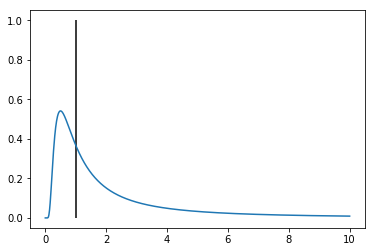

In [72]:
x = np.linspace(1e-4,10,num=1000)
plt.plot(x, np.exp(invgamma.logpdf(x, 1.0)))
plt.vlines(1,0,1)

In [73]:
%%time
result = sampler.run_mcmc(np.random.rand(6), 10000)

CPU times: user 9.21 s, sys: 31.1 ms, total: 9.24 s
Wall time: 9.28 s


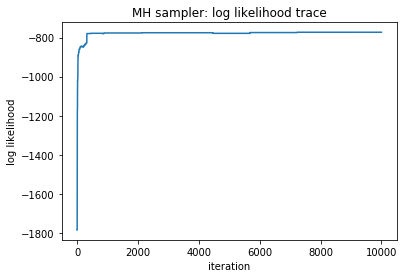

In [74]:
plt.plot(sampler._lnprob.T)
plt.title('MH sampler: log likelihood trace')
plt.xlabel('iteration')
plt.ylabel('log likelihood')

plt.savefig('gmm_likelihood_trace_MH.jpg')

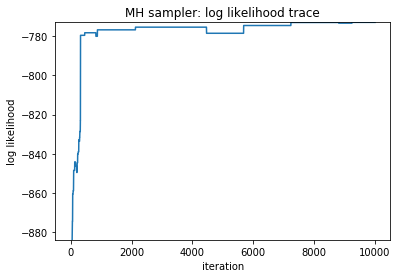

In [75]:
plt.plot(sampler._lnprob.T)

start = 50
#plt.xlim(start, len(sampler._lnprob.T))
plt.ylim(np.min(sampler._lnprob.T[start]), np.max(sampler._lnprob.T))
plt.title('MH sampler: log likelihood trace')
plt.xlabel('iteration')
plt.ylabel('log likelihood')
plt.savefig('gmm_likelihood_trace_zoomed_in_MH.jpg')

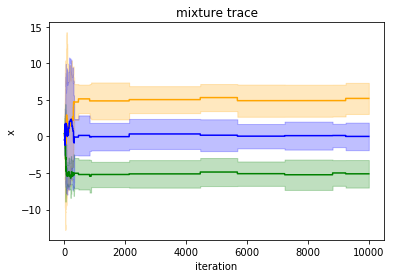

In [76]:
# figure that combines means and stdevs
chain = sampler.chain

colors = ['orange', 'green', 'blue']

for i in range(3):
    mean = chain[:,i]
    stdev = chain[:,i+3]
    color = colors[i]
    
    plt.plot(mean, color=color)
    plt.fill_between(np.arange(len(mean)), mean - 1.96 * stdev, mean + 1.96 * stdev, color=color, alpha=0.25)
plt.ylabel('x')
plt.xlabel('iteration')
plt.title('mixture trace')
plt.savefig('mixture-trace-MH.jpg')

Here we follow Richardson and Green: On Bayesian analysis of mixtures with an unknown number of components (1997)  https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/1467-9868.00095


We'll use a slice of what's described in Richardson / Green... In particular:
* Going to avoid doing anything with latent "allocation" variables z_i describing which mixture component observation i came from...
* Always going to force the weights to be uniform
* Not going to use the hierarchical model
* Not going to bother with smart Gibbs moves

So, to sum up: in section 3.2. we'll only be considering steps (b) and (e), and skipping updates of the weights, allocation, hyperparameter.
* For (b) we'll use basic random-walk Metropolis-Hastings
* For (e) we'll use merge / split moves as described

In [77]:
max_components = 50

def reversible_split_merge_move(theta):
    # unpack means, stdevs, and n_components
    means, stdevs = unpack(theta)
    n_components = len(means)
    
    # decide whether to split or merge
    if n_components == 1:
        split_probability = 1.0
    elif n_components == max_components:
        split_probability = 0.0
    else:
        split_probability = 0.5
    merge_probability = 1.0 - split_probability
    
    if np.random.rand() < split_probability:
        means, stdevs, log_jac_u_term = reversible_split_move(means, stdevs)
    else:
        means, stdevs, log_jac_u_term = reversible_merge_move(means, stdevs)
    assert(len(means) == len(stdevs))
    theta_prime = np.array(means + stdevs)
    return theta_prime, log_jac_u_term
    
from scipy.stats import beta
u_2_distribution = beta(2, 2)
u_3_distribution = beta(1, 1)

def reversible_merge_move(means, stdevs):
    means = list(means)
    stdevs = list(stdevs)
    
    #inds = np.argsort(means)
    #means = [means[i] for i in inds]
    #stdevs = [stdevs[i] for i in inds]
    
    ## pick two adjacent components to merge
    #j1 = np.random.randint(len(means) - 1)
    #j2 = j1 + 1
    
    # pick two random indices
    j1 = np.random.randint(len(means))
    j2 = np.random.randint(len(means))
    while j2 == j1:
        j2 = np.random.randint(len(means))
    
    # ensure j1 < j2
    if j1 > j2:
        j1, j2 = j2, j1
    
    # moment-match proposal
    m_1, m_2 = means[j1], means[j2]
    sigma_1, sigma_2 = stdevs[j1], stdevs[j2]
    new_mean = (m_1 + m_2) / 2
    new_stdev = np.sqrt(m_1**2 + sigma_1**2 + m_2**2 + sigma_2**2 - (m_1 + m_2)**2)
    
    # remove j1 and j2 from the means and stdevs
    _ = means.pop(j2)
    _ = means.pop(j1)
    _ = stdevs.pop(j2)
    _ = stdevs.pop(j1)
    
    # append the new component to the end of the list
    means.append(new_mean)
    stdevs.append(new_stdev)
    
    # Compute u_2, u_3, and jacobian
    # compute u_2 and u_3 that invert the transformation
    u_2 = (new_mean - m_1) / new_stdev
    k = len(means)
    u_3 = 1 - (sigma_2**2 / ((1 - (u_2**2)) * (new_stdev**2) * ((k + 1.0) / k)))
    
    #u_2, u_3 = 0, 0 # invert of the forward transformation
    #log_prob_u = u_2_distribution.logpdf(u_2) + u_3_distribution.logpdf(u_3)
    
    jacobian_inv = (m_1 - m_2 * sigma_1**2 * sigma_2**2) / (u_2 * (1 - u_2**2) * u_3 * (1 - u_3) * new_stdev**2)
    log_jacobian_inv = np.log(jacobian_inv)
    log_jacobian = - log_jacobian_inv
    #log_jac_u_term = log_jacobian - log_prob_u
    log_jac_u_term = log_jacobian
    
    ## keep it sorted
    #inds = np.argsort(means)
    #means = [means[i] for i in inds]
    #stdevs = [stdevs[i] for i in inds]
    
    return means, stdevs, log_jac_u_term

def reversible_split_move(means, stdevs):
    means = list(means)
    stdevs = list(stdevs)
    
    # u_1 not needed since no randomness in the weights
    ##u_1 = np.random.beta(2,2)
    
    # select a component at random
    j_star = np.random.randint(len(means))
    m_star = means[j_star]
    sigma_star = stdevs[j_star]
    
    # draw the dimension-matching variables
    u_2 = u_2_distribution.rvs()
    u_3 = u_3_distribution.rvs()
    
    # deterministic transformation

    # set means
    m_1 = m_star - (u_2 * sigma_star)
    m_2 = m_star + (u_2 * sigma_star)

    # set stdevs
    k = len(means)
    w_1 = w_2 = 1.0 / (1 + k)
    w_star = 1.0 / k
    sigma_1 = np.sqrt(u_3 * (1 - u_2**2) * sigma_star**2 * (w_star / w_1))
    sigma_2 = np.sqrt((1 - u_3) * (1 - u_2**2) * sigma_star**2 * (w_star / w_2))
    
    # log-jacobian: from last line of equation 11 in Richardson and green
    jacobian = (m_1 - m_2 * sigma_1**2 * sigma_2**2) / (u_2 * (1 - u_2**2) * u_3 * (1 - u_3) * sigma_star**2)
    log_jacobian = np.log(jacobian)
    
    # log probability of the random numbers we drew
    log_prob_u = u_2_distribution.logpdf(u_2) + u_3_distribution.logpdf(u_3)
    
    # remove the split component from the means and stdevs
    _ = means.pop(j_star)
    _ = stdevs.pop(j_star)
    
    # append the new components to the means and stdevs
    means.append(m_1)
    means.append(m_2)
    stdevs.append(sigma_1)
    stdevs.append(sigma_2)
    
    return means, stdevs, log_jacobian - log_prob_u

from tqdm import tqdm
def rjmcmc(theta, n_steps=10000):
    
    traj = [theta]
    old_log_p = flat_log_p(theta)
    
    for t in tqdm(range(n_steps)):
        # generate proposal
        if np.random.rand() < 0.1:
            theta_prime, log_jac_u_term = reversible_split_merge_move(theta)
        else:
            theta_prime = theta + np.random.randn(len(theta)) * 0.1
            log_jac_u_term = 0.0
           
        
        new_log_p = flat_log_p(theta_prime)
        log_prob_ratio = new_log_p - old_log_p
        #log_prob_ratio = (flat_log_p(theta_prime) - flat_log_p(theta))
        if not np.isfinite(new_log_p):
            A = 0
        else:
            A = min(1.0, np.exp(log_prob_ratio + log_jac_u_term))
    
        if np.random.rand() < A:
            theta = theta_prime
            old_log_p = new_log_p
            if len(theta) != len(traj[-1]):
                prev_dim = int(len(traj[-1]) / 2)
                current_dim = int(len(theta) / 2)
                assert(len(theta) % 2 == 0)

                print('{}: accepted a cross-model jump! # components: {} --> {}'.format(t, prev_dim, current_dim))
        traj.append(theta)
    return traj

In [86]:
def compute_transformation_and_jacobian_manually(u_2, u_3, m_star, sigma_star, k):
    
    # set means
    m_1 = m_star - (u_2 * sigma_star)
    m_2 = m_star + (u_2 * sigma_star)

    # set stdevs
    w_1 = w_2 = 1.0 / (1 + k)
    w_star = 1.0 / k
    sigma_1 = np.sqrt(u_3 * (1 - u_2**2) * sigma_star**2 * (w_star / w_1))
    sigma_2 = np.sqrt((1 - u_3) * (1 - u_2**2) * sigma_star**2 * (w_star / w_2))
    
    # log-jacobian: from last line of equation 11 in Richardson and green
    jacobian = (m_1 - m_2 * sigma_1**2 * sigma_2**2) / (u_2 * (1 - u_2**2) * u_3 * (1 - u_3) * sigma_star**2)
    log_jacobian = np.log(jacobian)
    
    return (m_1, sigma_1, m_2, sigma_2), log_jacobian

from autograd import grad

from autograd import numpy as np

def compute_m1(u_2, u_3, m_star, sigma_star, k):
    m_1 = m_star - (u_2 * sigma_star)
    return m_1

def compute_m2(u_2, u_3, m_star, sigma_star, k):
    m_2 = m_star + (u_2 * sigma_star)
    return m_2

def compute_sigma_1(u_2, u_3, m_star, sigma_star, k):
    w_1 = w_2 = 1.0 / (1 + k)
    w_star = 1.0 / k
    sigma_1 = np.sqrt(u_3 * (1 - u_2**2) * sigma_star**2 * (w_star / w_1))
    return sigma_1

def compute_sigma_2(u_2, u_3, m_star, sigma_star, k):
    w_1 = w_2 = 1.0 / (1 + k)
    w_star = 1.0 / k
    sigma_2 = np.sqrt((1 - u_3) * (1 - u_2**2) * sigma_star**2 * (w_star / w_2))
    return sigma_2

/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


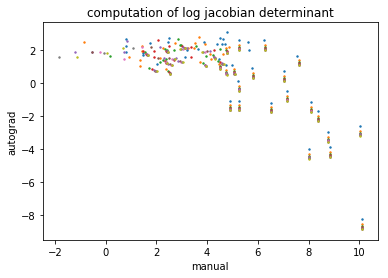

In [99]:
# let's compute the jacobian using autograd
X = []
for _ in range(100):
    u_2 = u_2_distribution.rvs()
    u_3 = u_3_distribution.rvs()
    m_star = np.random.randn() * 5
    sigma_star = np.random.rand() * 2
    
    X.append((u_2, u_3, m_star, sigma_star))
    

functions = [compute_m1, compute_m2, compute_sigma_1, compute_sigma_2]

def compute_jacobian(u_2, u_3, m_star, sigma_star, k):
    
    ins = u_2, u_3, m_star, sigma_star
    J = np.zeros((len(ins), len(functions)))
    
    for i in range(len(ins)):
        for j in range(len(functions)):
            J[i, j] = grad(functions[j], argnum=i)(u_2, u_3, m_star, sigma_star, k)
    return J
    

    
for k in range(1,10):
    manual = []
    autogradded = []
    for (u_2, u_3, m_star, sigma_star) in X:
        _, manual_log_jac = compute_transformation_and_jacobian_manually(u_2, u_3, m_star, sigma_star, k)
        manual.append(manual_log_jac)
        
        J = compute_jacobian(u_2, u_3, m_star, sigma_star, k)
        
        autogradded.append(np.log(np.linalg.det(J)))
    plt.scatter(manual, autogradded, s=2)
plt.xlabel('manual')
plt.ylabel('autograd')
plt.title('computation of log jacobian determinant')
        

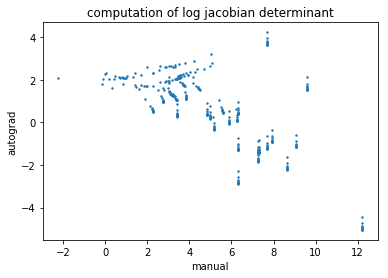

In [97]:
plt.scatter(manual, autogradded, s=2)
#plt.plot(autogradded, autogradded)
plt.xlabel('manual')
plt.ylabel('autograd')
plt.title('computation of log jacobian determinant')

In [110]:
max_components = 50

def autograd_reversible_split_merge_move(theta):
    # unpack means, stdevs, and n_components
    means, stdevs = unpack(theta)
    n_components = len(means)
    
    # decide whether to split or merge
    if n_components == 1:
        split_probability = 1.0
    elif n_components == max_components:
        split_probability = 0.0
    else:
        split_probability = 0.5
    merge_probability = 1.0 - split_probability
    
    if np.random.rand() < split_probability:
        means, stdevs, log_jac_u_term = autograd_reversible_split_move(means, stdevs)
    else:
        means, stdevs, log_jac_u_term = autograd_reversible_merge_move(means, stdevs)
    assert(len(means) == len(stdevs))
    theta_prime = np.array(means + stdevs)
    return theta_prime, log_jac_u_term
    
from scipy.stats import beta
u_2_distribution = beta(2, 2)
u_3_distribution = beta(1, 1)

def autograd_reversible_merge_move(means, stdevs):
    means = list(means)
    stdevs = list(stdevs)
    
    #inds = np.argsort(means)
    #means = [means[i] for i in inds]
    #stdevs = [stdevs[i] for i in inds]
    
    ## pick two adjacent components to merge
    #j1 = np.random.randint(len(means) - 1)
    #j2 = j1 + 1
    
    # pick two random indices
    j1 = np.random.randint(len(means))
    j2 = np.random.randint(len(means))
    while j2 == j1:
        j2 = np.random.randint(len(means))
    
    # ensure j1 < j2
    if j1 > j2:
        j1, j2 = j2, j1
    
    # moment-match proposal
    m_1, m_2 = means[j1], means[j2]
    sigma_1, sigma_2 = stdevs[j1], stdevs[j2]
    m_star = (m_1 + m_2) / 2
    sigma_star = np.sqrt(m_1**2 + sigma_1**2 + m_2**2 + sigma_2**2 - (m_1 + m_2)**2)
    
    # remove j1 and j2 from the means and stdevs
    _ = means.pop(j2)
    _ = means.pop(j1)
    _ = stdevs.pop(j2)
    _ = stdevs.pop(j1)
    
    # append the new component to the end of the list
    means.append(m_star)
    stdevs.append(sigma_star)
    
    # Compute u_2, u_3, and jacobian
    # compute u_2 and u_3 that invert the transformation
    u_2 = (m_star - m_1) / sigma_star
    k = len(means)
    u_3 = 1 - (sigma_2**2 / ((1 - (u_2**2)) * (sigma_star**2) * ((k + 1.0) / k)))
    
    #u_2, u_3 = 0, 0 # invert of the forward transformation
    log_prob_u = u_2_distribution.logpdf(u_2) + u_3_distribution.logpdf(u_3)
    
    log_jacobian = - np.log(np.linalg.det(compute_jacobian(u_2, u_3, m_star, sigma_star, k)))
    log_jac_u_term = log_jacobian
    
    ## keep it sorted
    #inds = np.argsort(means)
    #means = [means[i] for i in inds]
    #stdevs = [stdevs[i] for i in inds]
    
    return means, stdevs, log_jac_u_term

def autograd_reversible_split_move(means, stdevs):
    means = list(means)
    stdevs = list(stdevs)
    
    # u_1 not needed since no randomness in the weights
    ##u_1 = np.random.beta(2,2)
    
    # select a component at random
    j_star = np.random.randint(len(means))
    m_star = means[j_star]
    sigma_star = stdevs[j_star]
    
    # draw the dimension-matching variables
    u_2 = u_2_distribution.rvs()
    u_3 = u_3_distribution.rvs()
    
    # deterministic transformation

    # set means
    m_1 = m_star - (u_2 * sigma_star)
    m_2 = m_star + (u_2 * sigma_star)

    # set stdevs
    k = len(means)
    w_1 = w_2 = 1.0 / (1 + k)
    w_star = 1.0 / k
    sigma_1 = np.sqrt(u_3 * (1 - u_2**2) * sigma_star**2 * (w_star / w_1))
    sigma_2 = np.sqrt((1 - u_3) * (1 - u_2**2) * sigma_star**2 * (w_star / w_2))
    
    # log-jacobian: from last line of equation 11 in Richardson and green
    #jacobian = (m_1 - m_2 * sigma_1**2 * sigma_2**2) / (u_2 * (1 - u_2**2) * u_3 * (1 - u_3) * sigma_star**2)
    #log_jacobian = np.log(jacobian)
    log_jacobian = np.log(np.linalg.det(compute_jacobian(u_2, u_3, m_star, sigma_star, k)))
    
    # log probability of the random numbers we drew
    log_prob_u = u_2_distribution.logpdf(u_2) + u_3_distribution.logpdf(u_3)
    
    # remove the split component from the means and stdevs
    _ = means.pop(j_star)
    _ = stdevs.pop(j_star)
    
    # append the new components to the means and stdevs
    means.append(m_1)
    means.append(m_2)
    stdevs.append(sigma_1)
    stdevs.append(sigma_2)
    
    return means, stdevs, log_jacobian - log_prob_u

from tqdm import tqdm
def autograd_rjmcmc(theta, n_steps=10000):
    
    traj = [theta]
    old_log_p = flat_log_p(theta)
    
    for t in tqdm(range(n_steps)):
        # generate proposal
        if np.random.rand() < 0.1:
            theta_prime, log_jac_u_term = autograd_reversible_split_merge_move(theta)
        else:
            theta_prime = theta + np.random.randn(len(theta)) * 0.1
            log_jac_u_term = 0.0
           
        
        new_log_p = flat_log_p(theta_prime)
        log_prob_ratio = new_log_p - old_log_p
        #log_prob_ratio = (flat_log_p(theta_prime) - flat_log_p(theta))
        if not np.isfinite(new_log_p):
            A = 0
        else:
            A = min(1.0, np.exp(log_prob_ratio + log_jac_u_term))
    
        if np.random.rand() < A:
            theta = theta_prime
            old_log_p = new_log_p
            if len(theta) != len(traj[-1]):
                prev_dim = int(len(traj[-1]) / 2)
                current_dim = int(len(theta) / 2)
                assert(len(theta) % 2 == 0)

                print('{}: accepted a cross-model jump! # components: {} --> {}'.format(t, prev_dim, current_dim))
        traj.append(theta)
    return traj

In [111]:


np.random.seed(0)
init_n_components = 1
init_means = np.random.randn(init_n_components)
init_stdevs = np.random.rand(init_n_components) + 1
init_theta = np.hstack([init_means, init_stdevs])
traj = autograd_rjmcmc(init_theta, n_steps=10000)


  0%|          | 0/10000 [00:00<?, ?it/s]/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")

  2%|▏         | 207/10000 [00:00<00:09, 1069.19it/s]

3: accepted a cross-model jump! # components: 1 --> 2
38: accepted a cross-model jump! # components: 2 --> 1
55: accepted a cross-model jump! # components: 1 --> 2
122: accepted a cross-model jump! # components: 2 --> 3


/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:97: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.sqrt,    lambda ans, x : lambda g: g * 0.5 * x**-0.5)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/numpy/linalg/linalg.py:1874: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)

  3%|▎         | 292/10000 [00:00<00:09, 990.60it/s] /Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/joshuafass/anaconda/lib/pyth

212: accepted a cross-model jump! # components: 3 --> 2
222: accepted a cross-model jump! # components: 2 --> 1
231: accepted a cross-model jump! # components: 1 --> 2
304: accepted a cross-model jump! # components: 2 --> 3
333: accepted a cross-model jump! # components: 3 --> 4
362: accepted a cross-model jump! # components: 4 --> 5



  6%|▌         | 574/10000 [00:00<00:12, 744.35it/s]

436: accepted a cross-model jump! # components: 5 --> 4
490: accepted a cross-model jump! # components: 4 --> 3
505: accepted a cross-model jump! # components: 3 --> 4
566: accepted a cross-model jump! # components: 4 --> 5



  6%|▋         | 642/10000 [00:00<00:13, 683.92it/s]

578: accepted a cross-model jump! # components: 5 --> 6
597: accepted a cross-model jump! # components: 6 --> 5
612: accepted a cross-model jump! # components: 5 --> 4
693: accepted a cross-model jump! # components: 4 --> 3



  9%|▊         | 871/10000 [00:01<00:12, 724.44it/s]

784: accepted a cross-model jump! # components: 3 --> 2
827: accepted a cross-model jump! # components: 2 --> 3
833: accepted a cross-model jump! # components: 3 --> 2
847: accepted a cross-model jump! # components: 2 --> 3
956: accepted a cross-model jump! # components: 3 --> 2



 12%|█▏        | 1218/10000 [00:01<00:10, 826.38it/s]

1052: accepted a cross-model jump! # components: 2 --> 3



 14%|█▍        | 1385/10000 [00:01<00:10, 822.03it/s]

1248: accepted a cross-model jump! # components: 3 --> 2
1304: accepted a cross-model jump! # components: 2 --> 3
1323: accepted a cross-model jump! # components: 3 --> 2
1361: accepted a cross-model jump! # components: 2 --> 3
1404: accepted a cross-model jump! # components: 3 --> 2



 16%|█▋        | 1633/10000 [00:02<00:10, 792.53it/s]

1470: accepted a cross-model jump! # components: 2 --> 3
1497: accepted a cross-model jump! # components: 3 --> 2
1543: accepted a cross-model jump! # components: 2 --> 3
1570: accepted a cross-model jump! # components: 3 --> 4
1588: accepted a cross-model jump! # components: 4 --> 5



 19%|█▊        | 1867/10000 [00:02<00:11, 735.83it/s]

1747: accepted a cross-model jump! # components: 5 --> 4



 21%|██        | 2097/10000 [00:02<00:10, 746.14it/s]

1944: accepted a cross-model jump! # components: 4 --> 3
2025: accepted a cross-model jump! # components: 3 --> 4



 22%|██▏       | 2249/10000 [00:02<00:10, 741.79it/s]

2146: accepted a cross-model jump! # components: 4 --> 5



 25%|██▌       | 2507/10000 [00:03<00:09, 804.49it/s]

2373: accepted a cross-model jump! # components: 5 --> 4
2395: accepted a cross-model jump! # components: 4 --> 3
2402: accepted a cross-model jump! # components: 3 --> 2
2509: accepted a cross-model jump! # components: 2 --> 3



 28%|██▊       | 2780/10000 [00:03<00:08, 877.24it/s]

2617: accepted a cross-model jump! # components: 3 --> 2
2657: accepted a cross-model jump! # components: 2 --> 3
2669: accepted a cross-model jump! # components: 3 --> 2



 33%|███▎      | 3276/10000 [00:04<00:07, 871.00it/s]

3131: accepted a cross-model jump! # components: 2 --> 3
3140: accepted a cross-model jump! # components: 3 --> 4
3276: accepted a cross-model jump! # components: 4 --> 5



 34%|███▍      | 3446/10000 [00:04<00:09, 704.28it/s]

3346: accepted a cross-model jump! # components: 5 --> 4



 37%|███▋      | 3690/10000 [00:04<00:08, 777.38it/s]

3559: accepted a cross-model jump! # components: 4 --> 3
3572: accepted a cross-model jump! # components: 3 --> 2
3657: accepted a cross-model jump! # components: 2 --> 3
3716: accepted a cross-model jump! # components: 3 --> 2
3721: accepted a cross-model jump! # components: 2 --> 1



 39%|███▊      | 3852/10000 [00:04<00:08, 751.42it/s]

3771: accepted a cross-model jump! # components: 1 --> 2
3773: accepted a cross-model jump! # components: 2 --> 3
3777: accepted a cross-model jump! # components: 3 --> 4
3778: accepted a cross-model jump! # components: 4 --> 3
3868: accepted a cross-model jump! # components: 3 --> 4



 41%|████      | 4076/10000 [00:05<00:08, 700.74it/s]

3942: accepted a cross-model jump! # components: 4 --> 3
4019: accepted a cross-model jump! # components: 3 --> 4



 42%|████▏     | 4239/10000 [00:05<00:07, 747.58it/s]

4140: accepted a cross-model jump! # components: 4 --> 3
4200: accepted a cross-model jump! # components: 3 --> 4



 45%|████▍     | 4473/10000 [00:05<00:07, 751.72it/s]

4382: accepted a cross-model jump! # components: 4 --> 3
4429: accepted a cross-model jump! # components: 3 --> 4
4446: accepted a cross-model jump! # components: 4 --> 3
4472: accepted a cross-model jump! # components: 3 --> 4
4532: accepted a cross-model jump! # components: 4 --> 3



 47%|████▋     | 4716/10000 [00:06<00:06, 760.51it/s]

4612: accepted a cross-model jump! # components: 3 --> 4
4650: accepted a cross-model jump! # components: 4 --> 3
4729: accepted a cross-model jump! # components: 3 --> 2
4734: accepted a cross-model jump! # components: 2 --> 1
4769: accepted a cross-model jump! # components: 1 --> 2



 49%|████▉     | 4895/10000 [00:06<00:06, 812.43it/s]/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)

 50%|████▉     | 4978/10000 [00:06<00:06, 800.74it/s]

4859: accepted a cross-model jump! # components: 2 --> 3
4955: accepted a cross-model jump! # components: 3 --> 2
4981: accepted a cross-model jump! # components: 2 --> 1



 51%|█████▏    | 5139/10000 [00:06<00:06, 767.06it/s]

5038: accepted a cross-model jump! # components: 1 --> 2
5040: accepted a cross-model jump! # components: 2 --> 3
5057: accepted a cross-model jump! # components: 3 --> 4
5099: accepted a cross-model jump! # components: 4 --> 5
5104: accepted a cross-model jump! # components: 5 --> 4



 53%|█████▎    | 5309/10000 [00:06<00:06, 772.98it/s]

5209: accepted a cross-model jump! # components: 4 --> 3
5266: accepted a cross-model jump! # components: 3 --> 2
5324: accepted a cross-model jump! # components: 2 --> 3



 56%|█████▋    | 5630/10000 [00:07<00:05, 752.40it/s]

5484: accepted a cross-model jump! # components: 3 --> 4



 59%|█████▉    | 5875/10000 [00:07<00:05, 785.27it/s]

5719: accepted a cross-model jump! # components: 4 --> 3
5726: accepted a cross-model jump! # components: 3 --> 2
5734: accepted a cross-model jump! # components: 2 --> 1
5739: accepted a cross-model jump! # components: 1 --> 2
5846: accepted a cross-model jump! # components: 2 --> 3
5867: accepted a cross-model jump! # components: 3 --> 4
5877: accepted a cross-model jump! # components: 4 --> 3



 60%|██████    | 6041/10000 [00:07<00:05, 775.14it/s]

5910: accepted a cross-model jump! # components: 3 --> 4
5913: accepted a cross-model jump! # components: 4 --> 3



 62%|██████▏   | 6221/10000 [00:07<00:04, 826.26it/s]

6087: accepted a cross-model jump! # components: 3 --> 2
6261: accepted a cross-model jump! # components: 2 --> 3



 64%|██████▍   | 6388/10000 [00:08<00:04, 812.49it/s]

6281: accepted a cross-model jump! # components: 3 --> 2
6289: accepted a cross-model jump! # components: 2 --> 3
6316: accepted a cross-model jump! # components: 3 --> 2
6348: accepted a cross-model jump! # components: 2 --> 3
6366: accepted a cross-model jump! # components: 3 --> 4
6377: accepted a cross-model jump! # components: 4 --> 5
6386: accepted a cross-model jump! # components: 5 --> 4
6414: accepted a cross-model jump! # components: 4 --> 5



 65%|██████▌   | 6547/10000 [00:08<00:05, 675.85it/s]

6490: accepted a cross-model jump! # components: 5 --> 6
6521: accepted a cross-model jump! # components: 6 --> 5
6543: accepted a cross-model jump! # components: 5 --> 4



 69%|██████▉   | 6921/10000 [00:08<00:04, 735.68it/s]

6788: accepted a cross-model jump! # components: 4 --> 3
6820: accepted a cross-model jump! # components: 3 --> 4



 73%|███████▎  | 7260/10000 [00:09<00:03, 807.38it/s]

7092: accepted a cross-model jump! # components: 4 --> 3
7152: accepted a cross-model jump! # components: 3 --> 4
7251: accepted a cross-model jump! # components: 4 --> 3



 74%|███████▍  | 7437/10000 [00:09<00:03, 847.01it/s]

7287: accepted a cross-model jump! # components: 3 --> 4
7337: accepted a cross-model jump! # components: 4 --> 3
7403: accepted a cross-model jump! # components: 3 --> 2
7429: accepted a cross-model jump! # components: 2 --> 3



 76%|███████▌  | 7617/10000 [00:09<00:02, 871.61it/s]

7471: accepted a cross-model jump! # components: 3 --> 2
7671: accepted a cross-model jump! # components: 2 --> 3


 78%|███████▊  | 7800/10000 [00:09<00:02, 891.22it/s]


7694: accepted a cross-model jump! # components: 3 --> 2
7751: accepted a cross-model jump! # components: 2 --> 3
7781: accepted a cross-model jump! # components: 3 --> 2
7790: accepted a cross-model jump! # components: 2 --> 1


 80%|███████▉  | 7989/10000 [00:10<00:02, 907.07it/s]

7884: accepted a cross-model jump! # components: 1 --> 2
7916: accepted a cross-model jump! # components: 2 --> 3
7967: accepted a cross-model jump! # components: 3 --> 4
8030: accepted a cross-model jump! # components: 4 --> 3


 83%|████████▎ | 8259/10000 [00:10<00:02, 856.12it/s]

8105: accepted a cross-model jump! # components: 3 --> 4
8116: accepted a cross-model jump! # components: 4 --> 3


 85%|████████▍ | 8451/10000 [00:10<00:01, 889.62it/s]

8332: accepted a cross-model jump! # components: 3 --> 2
8335: accepted a cross-model jump! # components: 2 --> 1
8350: accepted a cross-model jump! # components: 1 --> 2
8479: accepted a cross-model jump! # components: 2 --> 3


 86%|████████▋ | 8631/10000 [00:10<00:01, 818.21it/s]

8545: accepted a cross-model jump! # components: 3 --> 2
8548: accepted a cross-model jump! # components: 2 --> 1
8574: accepted a cross-model jump! # components: 1 --> 2
8579: accepted a cross-model jump! # components: 2 --> 3
8583: accepted a cross-model jump! # components: 3 --> 4
8588: accepted a cross-model jump! # components: 4 --> 3
8673: accepted a cross-model jump! # components: 3 --> 4


 89%|████████▉ | 8887/10000 [00:11<00:01, 814.63it/s]

8739: accepted a cross-model jump! # components: 4 --> 3
8908: accepted a cross-model jump! # components: 3 --> 2


 91%|█████████ | 9075/10000 [00:11<00:01, 842.12it/s]

8952: accepted a cross-model jump! # components: 2 --> 3
9026: accepted a cross-model jump! # components: 3 --> 2
9038: accepted a cross-model jump! # components: 2 --> 1
9068: accepted a cross-model jump! # components: 1 --> 2


 93%|█████████▎| 9337/10000 [00:11<00:00, 841.45it/s]

9247: accepted a cross-model jump! # components: 2 --> 3
9263: accepted a cross-model jump! # components: 3 --> 2
9285: accepted a cross-model jump! # components: 2 --> 3


 95%|█████████▌| 9527/10000 [00:12<00:00, 829.49it/s]

9445: accepted a cross-model jump! # components: 3 --> 4
9449: accepted a cross-model jump! # components: 4 --> 3
9578: accepted a cross-model jump! # components: 3 --> 4


 99%|█████████▉| 9880/10000 [00:12<00:00, 853.10it/s]

9705: accepted a cross-model jump! # components: 4 --> 3


100%|██████████| 10000/10000 [00:12<00:00, 795.58it/s]

9903: accepted a cross-model jump! # components: 3 --> 2
9905: accepted a cross-model jump! # components: 2 --> 1
9953: accepted a cross-model jump! # components: 1 --> 2


In [112]:
n_components_traj = [int(len(theta) / 2) for theta in traj]

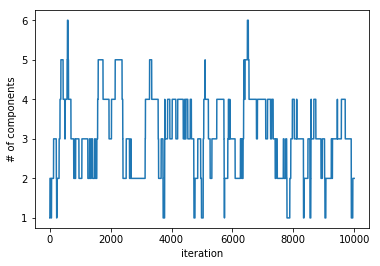

In [113]:
plt.plot(n_components_traj)
plt.xlabel('iteration')
plt.ylabel('# of components')
plt.savefig('rjmc-component-trace.jpg')

(array([ 390.,    0., 2525.,    0., 3566.,    0., 2801.,    0.,  669.,
          50.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <a list of 10 Patch objects>)

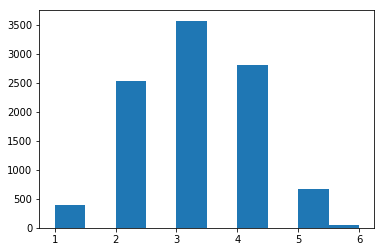

In [114]:
plt.hist(n_components_traj)

In [116]:
change_points = list(np.arange(1, len(n_components_traj))[np.diff(n_components_traj) != 0])
print(change_points)

[4, 39, 56, 123, 213, 223, 232, 305, 334, 363, 437, 491, 506, 567, 579, 598, 613, 694, 785, 828, 834, 848, 957, 1053, 1249, 1305, 1324, 1362, 1405, 1471, 1498, 1544, 1571, 1589, 1748, 1945, 2026, 2147, 2374, 2396, 2403, 2510, 2618, 2658, 2670, 3132, 3141, 3277, 3347, 3560, 3573, 3658, 3717, 3722, 3772, 3774, 3778, 3779, 3869, 3943, 4020, 4141, 4201, 4383, 4430, 4447, 4473, 4533, 4613, 4651, 4730, 4735, 4770, 4860, 4956, 4982, 5039, 5041, 5058, 5100, 5105, 5210, 5267, 5325, 5485, 5720, 5727, 5735, 5740, 5847, 5868, 5878, 5911, 5914, 6088, 6262, 6282, 6290, 6317, 6349, 6367, 6378, 6387, 6415, 6491, 6522, 6544, 6789, 6821, 7093, 7153, 7252, 7288, 7338, 7404, 7430, 7472, 7672, 7695, 7752, 7782, 7791, 7885, 7917, 7968, 8031, 8106, 8117, 8333, 8336, 8351, 8480, 8546, 8549, 8575, 8580, 8584, 8589, 8674, 8740, 8909, 8953, 9027, 9039, 9069, 9248, 9264, 9286, 9446, 9450, 9579, 9706, 9904, 9906, 9954]


In [117]:
trajs = []
for (start, end) in list(zip([0] + change_points, change_points + [len(traj)])):
    trajs.append(np.array(traj[start:end]))
    print(trajs[-1].shape)

(4, 2)
(35, 4)
(17, 2)
(67, 4)
(90, 6)
(10, 4)
(9, 2)
(73, 4)
(29, 6)
(29, 8)
(74, 10)
(54, 8)
(15, 6)
(61, 8)
(12, 10)
(19, 12)
(15, 10)
(81, 8)
(91, 6)
(43, 4)
(6, 6)
(14, 4)
(109, 6)
(96, 4)
(196, 6)
(56, 4)
(19, 6)
(38, 4)
(43, 6)
(66, 4)
(27, 6)
(46, 4)
(27, 6)
(18, 8)
(159, 10)
(197, 8)
(81, 6)
(121, 8)
(227, 10)
(22, 8)
(7, 6)
(107, 4)
(108, 6)
(40, 4)
(12, 6)
(462, 4)
(9, 6)
(136, 8)
(70, 10)
(213, 8)
(13, 6)
(85, 4)
(59, 6)
(5, 4)
(50, 2)
(2, 4)
(4, 6)
(1, 8)
(90, 6)
(74, 8)
(77, 6)
(121, 8)
(60, 6)
(182, 8)
(47, 6)
(17, 8)
(26, 6)
(60, 8)
(80, 6)
(38, 8)
(79, 6)
(5, 4)
(35, 2)
(90, 4)
(96, 6)
(26, 4)
(57, 2)
(2, 4)
(17, 6)
(42, 8)
(5, 10)
(105, 8)
(57, 6)
(58, 4)
(160, 6)
(235, 8)
(7, 6)
(8, 4)
(5, 2)
(107, 4)
(21, 6)
(10, 8)
(33, 6)
(3, 8)
(174, 6)
(174, 4)
(20, 6)
(8, 4)
(27, 6)
(32, 4)
(18, 6)
(11, 8)
(9, 10)
(28, 8)
(76, 10)
(31, 12)
(22, 10)
(245, 8)
(32, 6)
(272, 8)
(60, 6)
(99, 8)
(36, 6)
(50, 8)
(66, 6)
(26, 4)
(42, 6)
(200, 4)
(23, 6)
(57, 4)
(30, 6)
(9, 4)
(94, 2)
(

In [118]:
trajs[1]

array([[0.92719794, 2.56760232, 2.19316257, 0.85373224],
       [0.96056537, 2.57094621, 2.2612193 , 0.69738257],
       [0.90389561, 2.53764047, 2.26595578, 0.84365661],
       [1.05739853, 2.42981267, 2.40550301, 1.02240502],
       [1.0004468 , 2.32123261, 2.46947661, 0.98381868],
       [0.92287056, 2.34608567, 2.46635207, 0.96987129],
       [0.92287056, 2.34608567, 2.46635207, 0.96987129],
       [0.87492858, 2.31534919, 2.42969968, 1.08184248],
       [0.82913634, 2.35788853, 2.42690256, 1.22944146],
       [0.82913634, 2.35788853, 2.42690256, 1.22944146],
       [0.82913634, 2.35788853, 2.42690256, 1.22944146],
       [0.82913634, 2.35788853, 2.42690256, 1.22944146],
       [0.87797899, 2.2587982 , 2.52869057, 1.2636002 ],
       [0.75289037, 2.35132328, 2.43821195, 1.44796936],
       [0.90544109, 2.34426755, 2.49862792, 1.49518426],
       [0.90544109, 2.34426755, 2.49862792, 1.49518426],
       [0.90544109, 2.34426755, 2.49862792, 1.49518426],
       [0.90544109, 2.34426755,

100%|██████████| 156/156 [00:00<00:00, 357.55it/s]


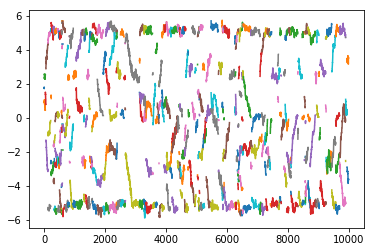

In [119]:
for i in tqdm(range(len(trajs))):
    x_init = sum([len(t) for t in trajs[:i]])
    x_end = x_init + len(trajs[i])
    n_components = int(trajs[i].shape[1] / 2)
    plt.plot(np.arange(x_init, x_end), trajs[i][:,:n_components])

(-5, 5)

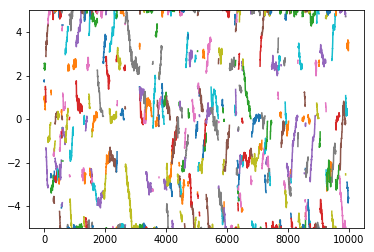

In [135]:
for i in range(len(trajs)):
    x_init = sum([len(t) for t in trajs[:i]])
    x_end = x_init + len(trajs[i])
    n_components = int(trajs[i].shape[1] / 2)
    plt.plot(np.arange(x_init, x_end), trajs[i][:,:n_components])
plt.ylim(-20,20)

(0, 1000)

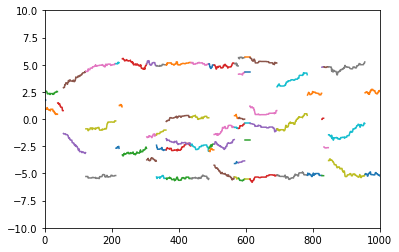

In [137]:
for i in range(len(trajs)):
    x_init = sum([len(t) for t in trajs[:i]])
    x_end = x_init + len(trajs[i])
    n_components = int(trajs[i].shape[1] / 2)
    plt.plot(np.arange(x_init, x_end), trajs[i][:,:n_components])
plt.ylim(-10,10)
plt.xlim(0,1000)

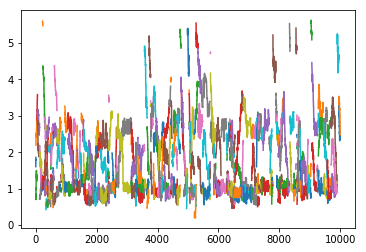

In [121]:
for i in range(len(trajs)):
    x_init = sum([len(t) for t in trajs[:i]])
    x_end = x_init + len(trajs[i])
    n_components = int(trajs[i].shape[1] / 2)
    plt.plot(np.arange(x_init, x_end), trajs[i][:,n_components:])

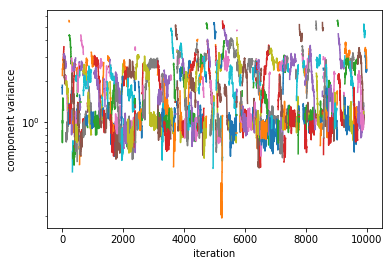

In [122]:
for i in range(len(trajs)):
    x_init = sum([len(t) for t in trajs[:i]])
    x_end = x_init + len(trajs[i])
    n_components = int(trajs[i].shape[1] / 2)
    plt.plot(np.arange(x_init, x_end), trajs[i][:,n_components:])
plt.yscale('log')
plt.ylabel('component variance')
plt.xlabel('iteration')
plt.savefig('rjmc-component-variance.jpg')

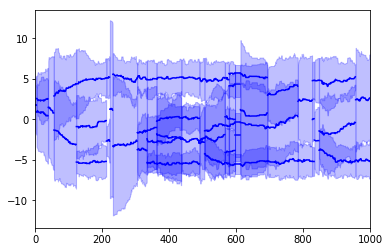

In [138]:
colors = ['blue'] * max_components
for i in range(len(trajs)):
    x_init = sum([len(t) for t in trajs[:i]])
    x_end = x_init + len(trajs[i])
    n_components = int(trajs[i].shape[1] / 2)
    
    t = trajs[i]
    
    for j in range(n_components):
        mean = t[:,j]
        stdev = t[:,j + n_components]
        color = colors[j]

        plt.plot(np.arange(x_init, x_end), mean, color=color)
        plt.fill_between(np.arange(x_init, x_end), mean - 1.96 * stdev, mean + 1.96 * stdev, color=color, alpha=0.25)
        
    plt.xlim(0,1000)

In [124]:
x_end

10001

In [29]:
from seaborn.apionly import color_palette

max_n_components = max([int(t.shape[1] / 2) for t in trajs])
colors = color_palette('pastel', max_n_components)

for i in range(len(trajs)):
    x_init = sum([len(t) for t in trajs[:i]])
    x_end = x_init + len(trajs[i])
    n_components = int(trajs[i].shape[1] / 2)
    
    t = trajs[i]
    
    
    for j in range(n_components):
        mean = t[:,j]
        stdev = t[:,j + n_components]
        color = colors[j]
    
        plt.plot(mean, color=color)
        plt.fill_between(np.arange(len(mean)), mean - 1.96 * stdev, mean + 1.96 * stdev, color=color, alpha=0.5 / n_components)
plt.xscale('log')

NameError: name 'trajs' is not defined

In [127]:
log_prior_trace = [log_prior(theta) for theta in tqdm(traj)]

100%|██████████| 10001/10001 [00:02<00:00, 3397.21it/s]


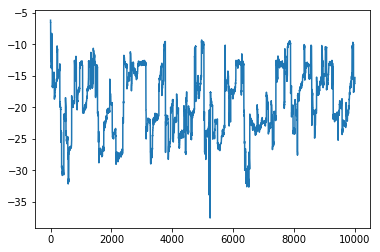

In [128]:
plt.plot(log_prior_trace)

In [129]:
log_prior_trace[20]

-13.716688463834918

In [130]:
log_prob_trace = [flat_log_p(theta) for theta in tqdm(traj)]

100%|██████████| 10001/10001 [00:08<00:00, 1184.51it/s]


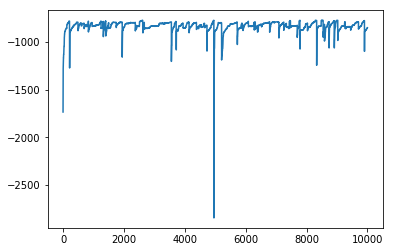

In [131]:
plt.plot(log_prob_trace)

(-859.1214449244903, -770.5020961415108)

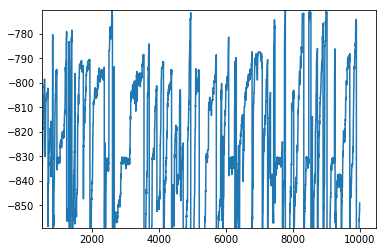

In [132]:
plt.plot(log_prob_trace)
plt.xlim(500,)
plt.ylim(log_prob_trace[500],max(log_prob_trace))

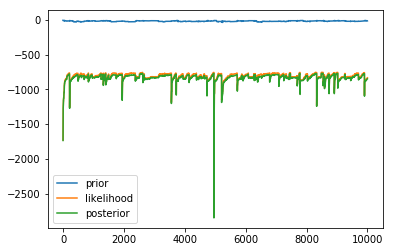

In [133]:
plt.plot(np.array(log_prior_trace), label='prior')
plt.plot(np.array(log_prob_trace) - np.array(log_prior_trace), label='likelihood')
plt.plot(np.array(log_prob_trace), label='posterior')
plt.legend(loc='best')

plt.savefig('rjmc-trace.jpg')

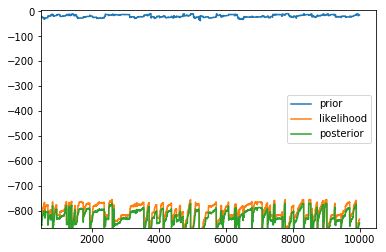

In [134]:
plt.plot(np.array(log_prior_trace), label='prior')
plt.plot(np.array(log_prob_trace) - np.array(log_prior_trace), label='likelihood')
plt.plot(np.array(log_prob_trace), label='posterior')
plt.legend(loc='best')

plt.xlim(500,)
plt.ylim(log_prob_trace[500] - 10, max(log_prior_trace) + 10)

plt.savefig('rjmc-trace-zoomed.jpg')